## Kütüphane işlemleri

In [1]:
import numpy as np #lineer cebir
import pandas as pd # veri işleme için yardımcı kütüphane

import matplotlib.pyplot as plt #veri görselleştirme
import seaborn as sns #veri görselleştirme

import nltk #metin madenciligi ön işleme sürecleri
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize #tokenizasyon
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer #lemmatizasyon


from wordcloud import WordCloud #word cloud veri görselleştime



# Import Tf-idf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer #veri dönüştürme

# Import the Label Encoder
from sklearn.preprocessing import LabelEncoder #katagorik degiskenler icin işleme


from sklearn.model_selection import train_test_split #verilerimizi bolme işlemi train ve test

# degerlendirmek icin metrikler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


#jupitere ozel surekli plt.show() yazmayi önlüyor
%matplotlib inline 

%config IPCompleter.greedy=True #akıllı kod tamamlama 

import warnings
warnings.filterwarnings('ignore') #uyarilari goz ardi etme 

### Veri setimizi okuyoruz ve içeriğine göz atıyoruz

In [2]:
data = pd.read_csv('SPAM text message 20170820 - Data.csv')

In [3]:
display(data.head()) #ilk 5 satıra bakıyoruz

display(data.describe()) #özet istatistikler

print(data.info()) #bilgiler
#veri setimizde 5572 mesaj bulunuyor 2 katagorimiz ve 5157 benzersiz mesajimiz var
#spam olmayan 4825 mesaj ve 747 spam mesajimiz var.

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


ham     4825
spam     747
Name: Category, dtype: int64

ham     0.865937
spam    0.134063
Name: Category, dtype: float64


Text(0.5, 1.0, 'Category Counts')

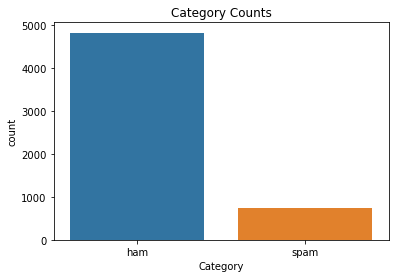

In [4]:
#katagori özelinde bilgiler
print(data['Category'].value_counts())

print()

print(data['Category'].value_counts(normalize=True)) #normalize edilmiş hali

#Görselleştiriliş hali
sns.countplot(data['Category'])
plt.title("Category Counts")

Veri setimiz dengesiz modelimizi oluşturuken bunu dikkate almalıyız

In [5]:
le = LabelEncoder()

# Katagorileri encode ediyoruz, yani sınıflarımızı 0 ve 1 olarak belirliyoruz
# ham=0, spam=1
data['Category_enc'] = le.fit_transform(data['Category'])

display(data.head())

print(data.dtypes)

,Category,Message,Category_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


Category        object
Message         object
Category_enc     int32
dtype: object


Category
ham     14.310259
spam    23.812584
Name: word_count, dtype: float64


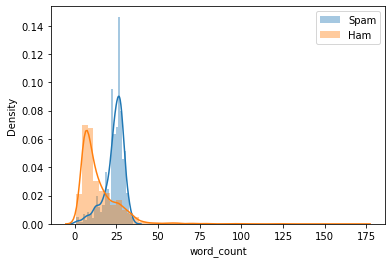

In [6]:
# Mesajlardaki kelime sayılarını saklıyoruz
data['word_count'] = data['Message'].str.split().str.len()

# Mesajlardaki ortalama kelime sayıları 
print(data.groupby('Category')['word_count'].mean())

# Görselleştirme
sns.distplot(data[data['Category']=='spam']['word_count'], label='Spam')#sütün grafiği
sns.distplot(data[data['Category']=='ham']['word_count'], label='Ham'),
plt.legend()#grafiğe açıklama eklemek için kullanıyoruz.

Spam mesajlar daha fazla kelime içermeye meyilli.

# Metin ön işleme aşamaları

## 1- Yinelenen verilerin temizlenmesi

In [7]:
#yinelenen verilerin kontrolü
duplicate = data[data.duplicated()] 
duplicate

,Category,Message,Category_enc,word_count
103,ham,As per your request 'Melle Melle (Oru Minnamin...,0,26
154,ham,As per your request 'Melle Melle (Oru Minnamin...,0,26
207,ham,"As I entered my cabin my PA said, '' Happy B'd...",0,32
223,ham,"Sorry, I'll call later",0,4
326,ham,No calls..messages..missed calls,0,3
...,...,...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...,1,25
5535,ham,"I know you are thinkin malaria. But relax, chi...",0,61
5539,ham,Just sleeping..and surfing,0,3
5553,ham,Hahaha..use your brain dear,0,4


In [8]:
#yinelenen verileri siliyoruz
data.drop_duplicates(inplace=True)

In [9]:
#tekrar kontrol ediyoruz
duplicate = data[data.duplicated()] 
duplicate

,Category,Message,Category_enc,word_count


## 2- Tokenizasyon

In [10]:
# Kelimeleri ayırıyoruz ve küçük harfe çeviriyoruz
tokenized_messages = data['Message'].str.lower().apply(word_tokenize)

print(tokenized_messages)

0       [go, until, jurong, point, ,, crazy, .., avail...
1                [ok, lar, ..., joking, wif, u, oni, ...]
2       [free, entry, in, 2, a, wkly, comp, to, win, f...
3       [u, dun, say, so, early, hor, ..., u, c, alrea...
4       [nah, i, do, n't, think, he, goes, to, usf, ,,...
                              ...                        
5567    [this, is, the, 2nd, time, we, have, tried, 2,...
5568      [will, ü, b, going, to, esplanade, fr, home, ?]
5569    [pity, ,, *, was, in, mood, for, that, ., so, ...
5570    [the, guy, did, some, bitching, but, i, acted,...
5571                  [rofl, ., its, true, to, its, name]
Name: Message, Length: 5157, dtype: object


## 3- Stopwordsleri ve alfa-nümerik olmayan karakterleri temizliyoruz

In [11]:
#Bu fonksiyon alfa nümerik olmayan herşeyi temizliyor.
def alpha(tokens):
    
    alpha = []
    for token in tokens:
        if str.isalpha(token) or token in ['n\'t','won\'t']:
            if token=='n\'t':
                alpha.append('not')
                continue
            elif token == 'won\'t':
                alpha.append('wont')
                continue
            alpha.append(token)
    return alpha

#fonksiyonumuzu uyguluyoruz
tokenized_messages = tokenized_messages.apply(alpha)

print(tokenized_messages)

0       [go, until, jurong, point, crazy, available, o...
1                          [ok, lar, joking, wif, u, oni]
2       [free, entry, in, a, wkly, comp, to, win, fa, ...
3       [u, dun, say, so, early, hor, u, c, already, t...
4       [nah, i, do, not, think, he, goes, to, usf, he...
                              ...                        
5567    [this, is, the, time, we, have, tried, contact...
5568         [will, ü, b, going, to, esplanade, fr, home]
5569    [pity, was, in, mood, for, that, so, any, othe...
5570    [the, guy, did, some, bitching, but, i, acted,...
5571                     [rofl, its, true, to, its, name]
Name: Message, Length: 5157, dtype: object


In [12]:
def remove_stop_words(tokens):
    #bu fonksiyon stopwords temizliyor
    no_stop = []
    #all_stopwords = stopwords.words('english')
    #all_stopwords.append('ju') # istenilen kelimenin verisetinden cikarilmasi

    for token in tokens:
        if token not in stopwords.words('english'):
            no_stop.append(token)
    return no_stop

# fonksiyonumuzu uyguluyoruz
tokenized_messages = tokenized_messages.apply(remove_stop_words)

print(tokenized_messages)

0       [go, jurong, point, crazy, available, bugis, n...
1                          [ok, lar, joking, wif, u, oni]
2       [free, entry, wkly, comp, win, fa, cup, final,...
3           [u, dun, say, early, hor, u, c, already, say]
4          [nah, think, goes, usf, lives, around, though]
                              ...                        
5567    [time, tried, contact, u, pound, prize, claim,...
5568                   [ü, b, going, esplanade, fr, home]
5569                            [pity, mood, suggestions]
5570    [guy, bitching, acted, like, interested, buyin...
5571                                   [rofl, true, name]
Name: Message, Length: 5157, dtype: object


## 4- Lemmatizasyon

In [13]:
def lemmatize(tokens):
    
    
    lemmatizer = WordNetLemmatizer()
    
    lemmatized = []
    for token in tokens:
            
            lemmatized.append(lemmatizer.lemmatize(token))
    return " ".join(lemmatized)

# fonksiyonumuzu uyguluyoruz
tokenized_messages = tokenized_messages.apply(lemmatize)

print(tokenized_messages)

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry wkly comp win fa cup final tkts may...
3                     u dun say early hor u c already say
4                     nah think go usf life around though
                              ...                        
5567    time tried contact u pound prize claim easy ca...
5568                          ü b going esplanade fr home
5569                                 pity mood suggestion
5570    guy bitching acted like interested buying some...
5571                                       rofl true name
Name: Message, Length: 5157, dtype: object


In [14]:
# Message sütunumuzu tokenized_messages ile değiştiriyoruz
data['Message'] = tokenized_messages

display(data.head())

,Category,Message,Category_enc,word_count
0,ham,go jurong point crazy available bugis n great ...,0,20
1,ham,ok lar joking wif u oni,0,6
2,spam,free entry wkly comp win fa cup final tkts may...,1,28
3,ham,u dun say early hor u c already say,0,11
4,ham,nah think go usf life around though,0,13


### En çok kullanılan kelimeleri görselleştiriyoruz

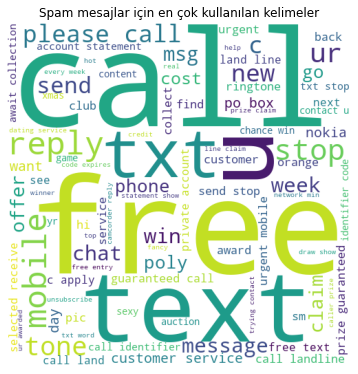

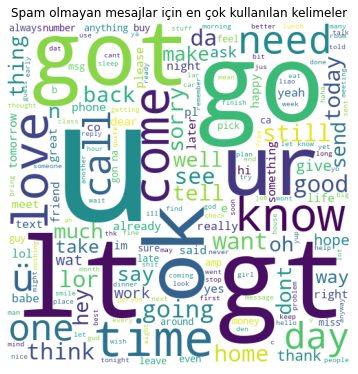

In [15]:
# spam mesajları alıyoruz
spam = data[data['Category']=='spam']['Message'].str.cat(sep=', ')

# spam olmayanları alıyoruz
ham = data[data['Category']=='ham']['Message'].str.cat(sep=', ')

# word cloudumuzu tanımlıyoruz
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color ='white')

# word cloud üretiyoruz her katagori için
spam_wc = wc.generate(spam)

plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(spam_wc) 
plt.axis("off") 
plt.title("Spam mesajlar için en çok kullanılan kelimeler")
plt.tight_layout(pad = 0) 
plt.show() 


ham_wc = wc.generate(ham)

plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(ham_wc) 
plt.axis("off")
plt.title("Spam olmayan mesajlar için en çok kullanılan kelimeler")
plt.tight_layout(pad = 0) 
plt.show() 

Görüldüğü üzere spam olmayan mesajlar çok sayıda kısaltma ve gayri resmi kelime içeriyor spam mesajlar ise daha belirgin

# Veri dönüştürme ve modelin oluşturulması

In [16]:
#özellik ve hedefi modele vermek için seçiyoruz
X = data['Message']
y = data['Category_enc']

In [17]:
#verimizi test ve train olarak bölüyoruz.Veri setimiz dengesiz oldugundan stratify parametresini kullaniyoruz.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34, stratify=y)

In [18]:
# veri dönüştürmek için tfidVectorizer kullanıyoruz
#terim frekansı ters  Ters Belge Frekansının kısaltması
#en önemli kelimeleri vektörize ediyoruz
vectorizer = TfidfVectorizer(strip_accents='ascii')

# Önce train setimizi vektörize ediyoruz
tfidf_train = vectorizer.fit_transform(X_train)

# Sonra test setimizi vektörize ediyoruz
tfidf_test = vectorizer.transform(X_test)



Multinomial Naive Bayes Classifier Classification Report

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       904
           1       1.00      0.77      0.87       128

    accuracy                           0.97      1032
   macro avg       0.98      0.89      0.93      1032
weighted avg       0.97      0.97      0.97      1032



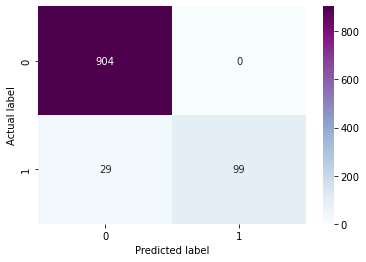

In [19]:
# Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

#modeli uyguluyoruz
nb.fit(tfidf_train, y_train)

#metriklerde kullanıcağımız tahminimiz
y_pred_nb=nb.predict(tfidf_test)

#karmaşıklık matrisi
from sklearn.metrics import confusion_matrix
cm=confusion_matrix( y_test,y_pred_nb)
sns.heatmap(cm,cmap='BuPu',annot=True,fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


#Performans raporu
cr = classification_report(y_test, y_pred_nb)
print("\n\nMultinomial Naive Bayes Classifier Classification Report\n")
print(cr)



Bernoulli Naive Bayes Classifier Classification Report

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       904
           1       1.00      0.77      0.87       128

    accuracy                           0.97      1032
   macro avg       0.98      0.89      0.93      1032
weighted avg       0.97      0.97      0.97      1032



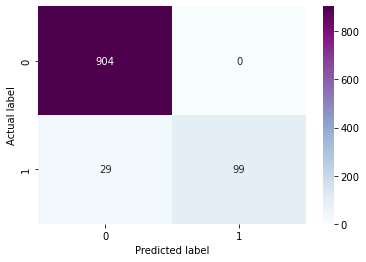

In [20]:
#Bernoulli Naive Bayes Classifier
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

#modeli uyguluyoruz
bnb.fit(tfidf_train, y_train)

#metriklerde kullanıcağımız tahminimiz
y_pred_bnb=bnb.predict(tfidf_test)

#karmaşıklık matrisi
cm=confusion_matrix(y_test,y_pred_bnb)
sns.heatmap(cm,cmap='BuPu',annot=True,fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

#Performans raporu
cr = classification_report(y_test, y_pred_bnb)
print("\n\nBernoulli Naive Bayes Classifier Classification Report\n")
print(cr)



Random Forest Classifier Classification Report

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       904
           1       0.97      0.80      0.88       128

    accuracy                           0.97      1032
   macro avg       0.97      0.90      0.93      1032
weighted avg       0.97      0.97      0.97      1032



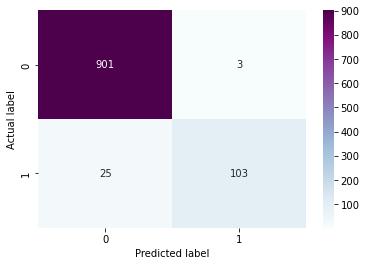

In [21]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=0)

#modeli uyguluyoruz
rfc.fit(tfidf_train, y_train)

#metriklerde kullanıcağımız tahminimiz
y_pred_rfc=rfc.predict(tfidf_test)

#karmaşıklık matrisi
cm=confusion_matrix(y_test,y_pred_rfc)
sns.heatmap(cm,cmap='BuPu',annot=True,fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


#Performans raporu
cr = classification_report(y_test, y_pred_rfc)
print("\n\nRandom Forest Classifier Classification Report\n")
print(cr)



Support Vector Machine Classification Report

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       904
           1       0.95      0.87      0.91       128

    accuracy                           0.98      1032
   macro avg       0.97      0.93      0.95      1032
weighted avg       0.98      0.98      0.98      1032



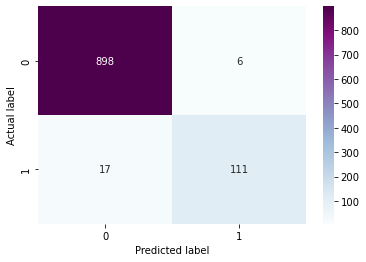

In [22]:
#Support Vector Machine
from sklearn.svm import SVC
svc = SVC(kernel='sigmoid', gamma=1.0)

#modeli uyguluyoruz
svc.fit(tfidf_train, y_train)

#metriklerde kullanıcağımız tahminimiz
y_pred_svc=svc.predict(tfidf_test)

#karmaşıklık matrisi
cm=confusion_matrix(y_test,y_pred_svc)
sns.heatmap(cm,cmap='BuPu',annot=True,fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


#Performans raporu
cr = classification_report(y_test, y_pred_svc)
print("\n\nSupport Vector Machine Classification Report\n")
print(cr)



Decision Tree Classifier Classification Report

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       904
           1       0.85      0.77      0.81       128

    accuracy                           0.96      1032
   macro avg       0.91      0.88      0.89      1032
weighted avg       0.95      0.96      0.95      1032



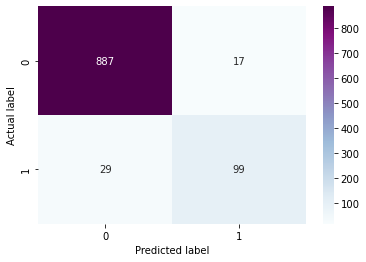

In [23]:
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

#modeli uyguluyoruz
dtc.fit(tfidf_train, y_train)

#metriklerde kullanıcağımız tahminimiz
y_pred_dtc=dtc.predict(tfidf_test)

#karmaşıklık matrisi
cm=confusion_matrix(y_test,y_pred_dtc)
sns.heatmap(cm,cmap='BuPu',annot=True,fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


#Performans raporu
cr = classification_report(y_test, y_pred_dtc)
print("\n\nDecision Tree Classifier Classification Report\n")
print(cr)



KNN Classification Report

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       904
           1       1.00      0.15      0.26       128

    accuracy                           0.89      1032
   macro avg       0.95      0.57      0.60      1032
weighted avg       0.91      0.89      0.86      1032



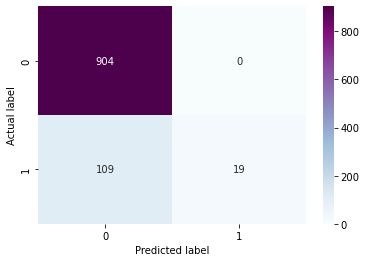

In [24]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 10)

#modeli uyguluyoruz
knn.fit(tfidf_train, y_train)

#metriklerde kullanıcağımız tahminimiz
y_pred_knn=knn.predict(tfidf_test)

#karmaşıklık matrisi
cm=confusion_matrix(y_test,y_pred_knn)
sns.heatmap(cm,cmap='BuPu',annot=True,fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


#Performans raporu
cr = classification_report(y_test, y_pred_knn)
print("\n\nKNN Classification Report\n")
print(cr)



Logistic Regression Classification Report

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       904
           1       0.97      0.71      0.82       128

    accuracy                           0.96      1032
   macro avg       0.96      0.85      0.90      1032
weighted avg       0.96      0.96      0.96      1032



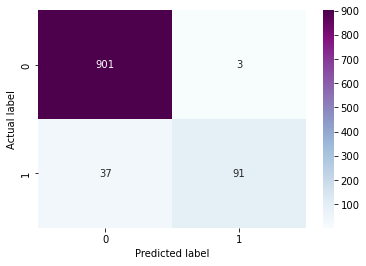

In [25]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter = 200)

#modeli uyguluyoruz
lr.fit(tfidf_train, y_train)

#metriklerde kullanıcağımız tahminimiz
y_pred_lr=lr.predict(tfidf_test)

#karmaşıklık matrisi
cm=confusion_matrix(y_test,y_pred_lr)
sns.heatmap(cm,cmap='BuPu',annot=True,fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


#Performans raporu
cr = classification_report(y_test, y_pred_lr)
print("\n\nLogistic Regression Classification Report\n")
print(cr)



Stochastic Gradient Descent Classifier Classification Report

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       904
           1       0.97      0.89      0.93       128

    accuracy                           0.98      1032
   macro avg       0.98      0.94      0.96      1032
weighted avg       0.98      0.98      0.98      1032



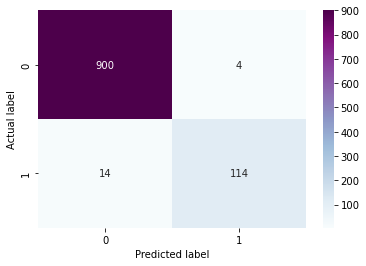

In [26]:
#Stochastic Gradient Descent Classifier
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", max_iter=200)

#modeli uyguluyoruz
clf.fit(tfidf_train, y_train)

#metriklerde kullanıcağımız tahminimiz
y_pred_clf=clf.predict(tfidf_test)

#karmaşıklık matrisi
cm=confusion_matrix(y_test,y_pred_clf)
sns.heatmap(cm,cmap='BuPu',annot=True,fmt='')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

#Performans raporu
cr = classification_report(y_test, y_pred_clf)
print("\n\nStochastic Gradient Descent Classifier Classification Report\n")
print(cr)

Text(0, 0.5, 'Accuracy')

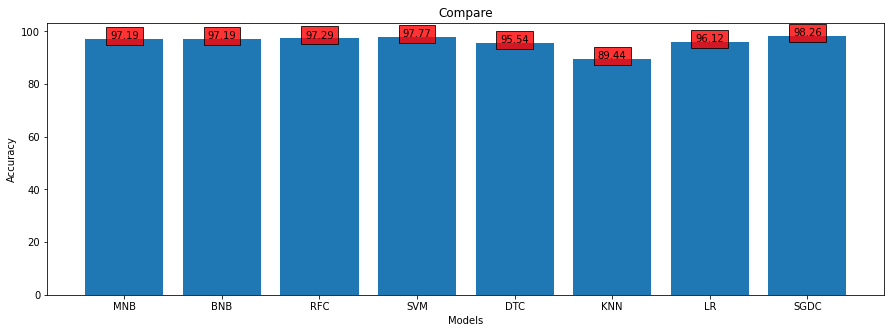

In [27]:
nb_acc=round(nb.score(tfidf_test, y_test)*100,2)
bnb_acc=round(bnb.score(tfidf_test, y_test)*100,2)
rfc_acc=round(rfc.score(tfidf_test, y_test)*100,2)
svc_acc=round(svc.score(tfidf_test, y_test)*100,2)
dtc_acc=round(dtc.score(tfidf_test, y_test)*100,2)
knn_acc=round(knn.score(tfidf_test, y_test)*100,2)
lr_acc=round(lr.score(tfidf_test, y_test)*100,2)
sgdc_acc=round(clf.score(tfidf_test, y_test)*100,2)

models = ['MNB','BNB','RFC','SVM','DTC','KNN','LR','SGDC']  
acc = [nb_acc,bnb_acc,rfc_acc,svc_acc,dtc_acc,knn_acc,lr_acc,sgdc_acc]  
def addlabels(models,acc):
    for i in range(len(models)):
        plt.text(i,acc[i],acc[i],ha = 'center',
                 Bbox = dict(facecolor = 'red', alpha =.8))
plt.figure(figsize = (15,5))
plt.bar(models,acc)
addlabels(models,acc)

plt.title('Compare')  
plt.xlabel('Models')  
plt.ylabel('Accuracy') 

Text(0, 0.5, 'Auc')

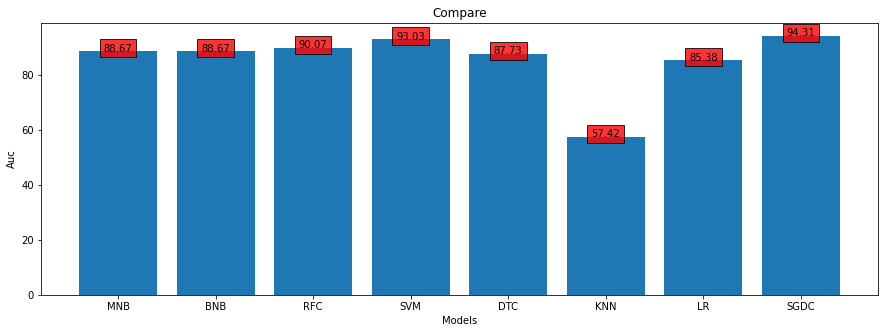

In [28]:
nb_auc=round(roc_auc_score(y_test, y_pred_nb)*100,2)
bnb_auc=round(roc_auc_score(y_test, y_pred_bnb)*100,2)
rfc_auc=round(roc_auc_score(y_test, y_pred_rfc)*100,2)
svc_auc=round(roc_auc_score(y_test, y_pred_svc)*100,2)
dtc_auc=round(roc_auc_score(y_test, y_pred_dtc)*100,2)
knn_auc=round(roc_auc_score(y_test, y_pred_knn)*100,2)
lr_auc=round(roc_auc_score(y_test, y_pred_lr)*100,2)
sgdc_auc=round(roc_auc_score(y_test, y_pred_clf)*100,2)

models = ['MNB','BNB','RFC','SVM','DTC','KNN','LR','SGDC']  
acc = [nb_auc,bnb_auc,rfc_auc,svc_auc,dtc_auc,knn_auc,lr_auc,sgdc_auc]  
def addlabels(models,acc):
    for i in range(len(models)):
        plt.text(i,acc[i],acc[i],ha = 'center',
                 Bbox = dict(facecolor = 'red', alpha =.8))
plt.figure(figsize = (15,5))
plt.bar(models,acc)
addlabels(models,acc)

plt.title('Compare')  
plt.xlabel('Models')  
plt.ylabel('Auc') 